In [107]:
#pip install xgboost
#pip install lightgbm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
import itertools
from itertools import product
color_pal = sns.color_palette()
pd.options.display.float_format = '{:,.2f}'.format   # Display floats with 2 decimal places
plt.style.use('fivethirtyeight')


In [108]:
df=pd.read_csv('consolidated_coin_data.csv')

In [109]:
df.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,tezos,2019-12-04,1.29,1.32,1.25,1.25,46048752,824588509
1,tezos,2019-12-03,1.24,1.32,1.21,1.29,41462224,853213342
2,tezos,2019-12-02,1.25,1.26,1.20,1.24,27574097,817872179
3,tezos,2019-12-01,1.33,1.34,1.25,1.25,24127567,828296390
4,tezos,2019-11-30,1.31,1.37,1.31,1.33,28706667,879181680


In [110]:
df.dropna()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,tezos,2019-12-04,1.29,1.32,1.25,1.25,46048752,824588509
1,tezos,2019-12-03,1.24,1.32,1.21,1.29,41462224,853213342
2,tezos,2019-12-02,1.25,1.26,1.20,1.24,27574097,817872179
3,tezos,2019-12-01,1.33,1.34,1.25,1.25,24127567,828296390
4,tezos,2019-11-30,1.31,1.37,1.31,1.33,28706667,879181680
...,...,...,...,...,...,...,...,...
28939,bitcoin-sv,2013-05-02,3.78,4.04,3.01,3.37,0,58287979
28940,bitcoin-sv,2013-05-01,4.29,4.36,3.52,3.80,0,65604596
28941,bitcoin-sv,2013-04-30,4.40,4.57,4.17,4.30,0,74020918
28942,bitcoin-sv,2013-04-29,4.37,4.57,4.23,4.38,0,75388964


In [111]:
df.drop_duplicates()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,tezos,2019-12-04,1.29,1.32,1.25,1.25,46048752,824588509
1,tezos,2019-12-03,1.24,1.32,1.21,1.29,41462224,853213342
2,tezos,2019-12-02,1.25,1.26,1.20,1.24,27574097,817872179
3,tezos,2019-12-01,1.33,1.34,1.25,1.25,24127567,828296390
4,tezos,2019-11-30,1.31,1.37,1.31,1.33,28706667,879181680
...,...,...,...,...,...,...,...,...
28939,bitcoin-sv,2013-05-02,3.78,4.04,3.01,3.37,0,58287979
28940,bitcoin-sv,2013-05-01,4.29,4.36,3.52,3.80,0,65604596
28941,bitcoin-sv,2013-04-30,4.40,4.57,4.17,4.30,0,74020918
28942,bitcoin-sv,2013-04-29,4.37,4.57,4.23,4.38,0,75388964


In [112]:
df.shape

(28944, 8)

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28944 entries, 0 to 28943
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Currency    28944 non-null  object 
 1   Date        28944 non-null  object 
 2   Open        28944 non-null  float64
 3   High        28944 non-null  float64
 4   Low         28944 non-null  float64
 5   Close       28944 non-null  float64
 6   Volume      28944 non-null  int64  
 7   Market Cap  28944 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 1.8+ MB


In [114]:
df.isnull()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
28939,False,False,False,False,False,False,False,False
28940,False,False,False,False,False,False,False,False
28941,False,False,False,False,False,False,False,False
28942,False,False,False,False,False,False,False,False


In [115]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,"28,944.00",300.72,"1,373.88",0.00,0.21,3.00,24.43,"19,475.80"
High,"28,944.00",309.83,"1,416.60",0.00,0.21,3.09,25.53,"20,089.00"
Low,"28,944.00",290.86,"1,325.07",0.00,0.20,2.88,23.27,"18,974.10"
Close,"28,944.00",300.95,"1,374.46",0.00,0.21,2.98,24.43,"19,497.40"
Volume,"28,944.00","813,305,774.24","3,059,515,679.37",0.00,"241,870.00","5,212,684.50","155,476,419.50","53,509,128,965.00"
Market Cap,"28,944.00","7,194,826,309.60","24,693,223,737.76",0.00,"63,451,426.00","345,367,261.00","3,422,402,834.50","326,502,485,530.00"


In [116]:
df.columns

Index(['Currency', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Market Cap'],
      dtype='object')

In [117]:
df.isnull().sum()

Currency      0
Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Market Cap    0
dtype: int64

In [118]:
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.index

DatetimeIndex(['2019-12-04', '2019-12-03', '2019-12-02', '2019-12-01',
               '2019-11-30', '2019-11-29', '2019-11-28', '2019-11-27',
               '2019-11-26', '2019-11-25',
               ...
               '2013-05-07', '2013-05-06', '2013-05-05', '2013-05-04',
               '2013-05-03', '2013-05-02', '2013-05-01', '2013-04-30',
               '2013-04-29', '2013-04-28'],
              dtype='datetime64[ns]', name='Date', length=28944, freq=None)

In [119]:
for col in df:
    print(df[col].unique())

['tezos' 'binance-coin' 'eos' 'bitcoin' 'tether' 'xrp' 'bitcoin-cash'
 'stellar' 'litecoin' 'ethereum' 'cardano' 'bitcoin-sv']
['2019-12-04' '2019-12-03' '2019-12-02' ... '2013-04-30' '2013-04-29'
 '2013-04-28']
[ 1.29  1.24  1.25 ... 87.7  70.27 88.3 ]
[  1.32   1.26   1.34 ... 125.11  98.51  89.57]
[ 1.25  1.21  1.2  ... 83.15 61.19 50.68]
[  1.25   1.29   1.24 ... 113.47  87.06  68.75]
[46048752 41462224 27574097 ...  8902820  4748070  2585660]
[ 824588509  853213342  817872179 ... 1711710041 1606993185 1952224634]


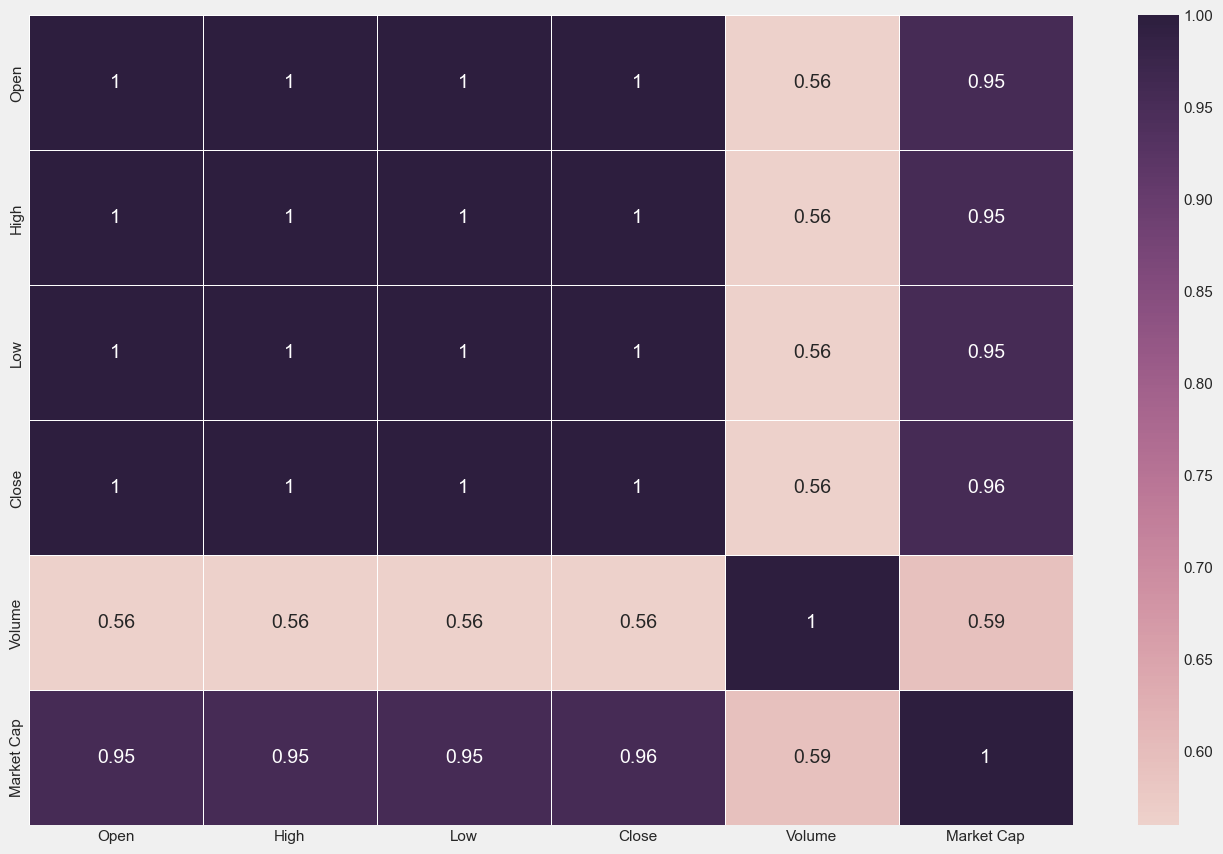

In [120]:
def corr_heatmap(data, figsize):
    fig, ax=plt.subplots(figsize=figsize)
    corr=data.corr(numeric_only=True)
    sns.heatmap(corr,cmap=sns.cubehelix_palette(10, 120, as_cmap=True), linewidths=.5, annot=True, ax=ax)
    
figsize=(15, 10)
corr_heatmap(df, figsize)

plt.savefig("Heatmap.png", dpi=600)

In [121]:
#sns.pairplot(df, kind='reg')
#plt.style.use('ggplot')

In [122]:
df_c=pd.get_dummies(data=df['Currency'], drop_first=False, dtype=int)
#Join faminsureco_converted and FamInsureCo_Data
df_d= pd.concat([df, df_c], axis=1)

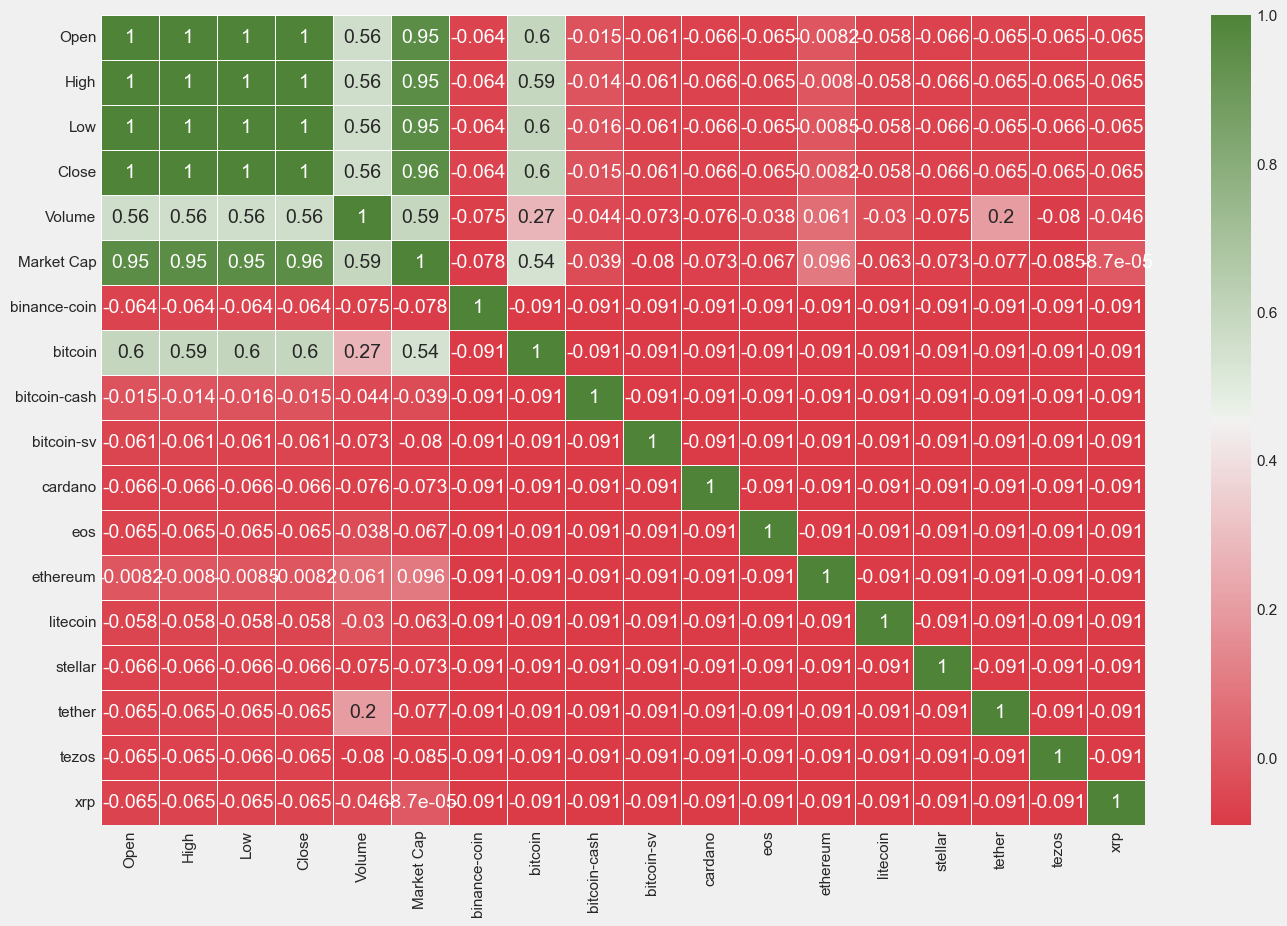

In [123]:
def corr_heatmap(data, figsize):
    fig, ax=plt.subplots(figsize=figsize)
    corr=data.corr(numeric_only=True)
    sns.heatmap(corr,cmap=sns.diverging_palette(10, 120, as_cmap=True), linewidths=.5, annot=True, ax=ax)
    
figsize=(15, 10)
corr_heatmap(df_d, figsize)

In [124]:
# Get all the bitcoin Currency
df_b = df[df['Currency'].str.contains('^bitcoin$')]

In [125]:
print(len(df_b))

2412


In [126]:
df_b.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,,
2019-12-04,bitcoin,2019-12-04,"7,320.13","7,539.78","7,170.92","7,252.03",21664240918,131143073943
2019-12-03,bitcoin,2019-12-03,"7,323.98","7,418.86","7,229.36","7,320.15",14797485769,132359942301
2019-12-02,bitcoin,2019-12-02,"7,424.04","7,474.82","7,233.40","7,321.99",17082040706,132378982377
2019-12-01,bitcoin,2019-12-01,"7,571.62","7,571.62","7,291.34","7,424.29",18720708479,134215145410
2019-11-30,bitcoin,2019-11-30,"7,764.06","7,836.10","7,515.85","7,569.63",17158194786,136829391049


In [127]:
df_b.tail()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,,,
2013-05-02,bitcoin,2013-05-02,116.38,125.60,92.28,105.21,0,1168517495
2013-05-01,bitcoin,2013-05-01,139.00,139.89,107.72,116.99,0,1298954594
2013-04-30,bitcoin,2013-04-30,144.00,146.93,134.05,139.00,0,1542813125
2013-04-29,bitcoin,2013-04-29,134.44,147.49,134.00,144.54,0,1603768865
2013-04-28,bitcoin,2013-04-28,135.30,135.98,132.10,134.21,0,1488566728


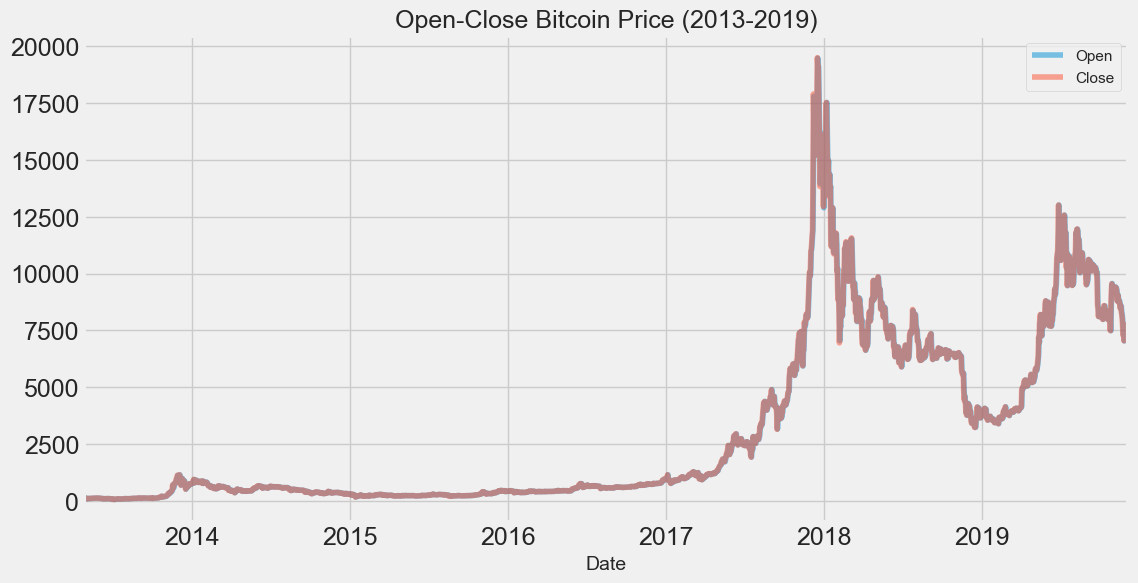

In [128]:
df_b[["Open", "Close"]].plot(figsize=(12,6), fontsize=18, alpha=0.5)
plt.title('Open-Close Bitcoin Price (2013-2019)', fontsize=18)
plt.savefig("Open-Close.png", dpi=600)

There is almost no variation between the opening and closing price of Bitcoin for the period of 2013-2019

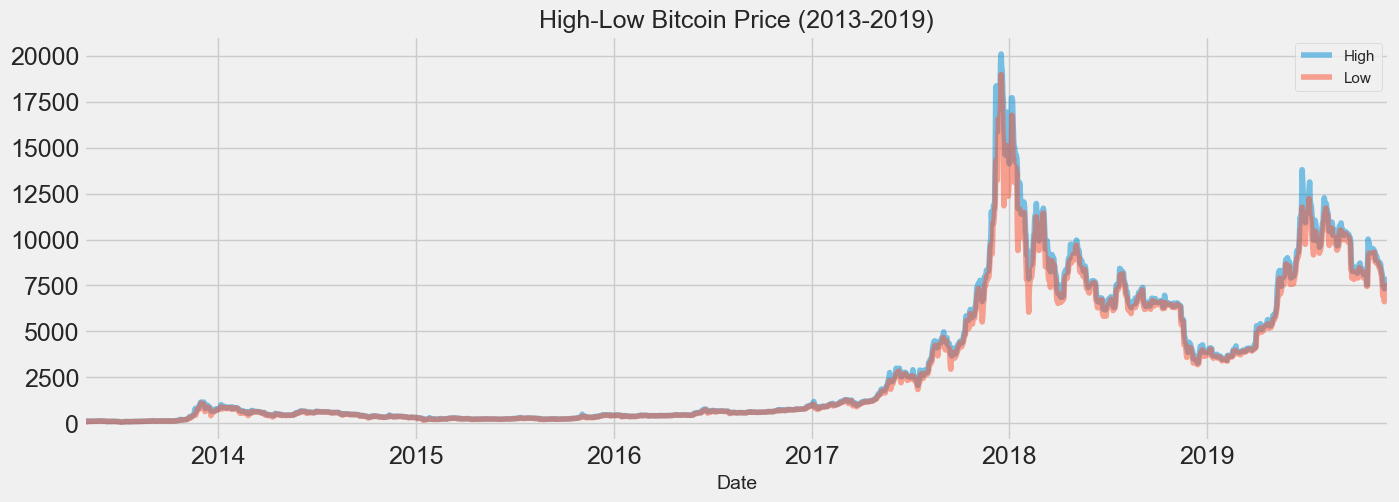

In [129]:
df_b[["High", "Low"]].plot(figsize=(15,5), fontsize=18, alpha=0.5)
plt.title('High-Low Bitcoin Price (2013-2019)', fontsize=18)
plt.savefig("High-Low.png", dpi=600)

Similarly there is no huge variation between the High and low price of Bitcoin for the period of 2013-2019.

In [130]:
df_bt=df_b.drop(['Open', 'High', 'Low', 'Volume',
       'Market Cap'], axis=1)
df_bt.iloc[1:10000]

,Currency,Date,Close
Date,,,
2019-12-03,bitcoin,2019-12-03,"7,320.15"
2019-12-02,bitcoin,2019-12-02,"7,321.99"
2019-12-01,bitcoin,2019-12-01,"7,424.29"
2019-11-30,bitcoin,2019-11-30,"7,569.63"
2019-11-29,bitcoin,2019-11-29,"7,761.24"
...,...,...,...
2013-05-02,bitcoin,2013-05-02,105.21
2013-05-01,bitcoin,2013-05-01,116.99
2013-04-30,bitcoin,2013-04-30,139.00


In [131]:
df_bt.index = pd.to_datetime(df_bt['Date'], format='%Y-%m-%d')
df_bt.index

DatetimeIndex(['2019-12-04', '2019-12-03', '2019-12-02', '2019-12-01',
               '2019-11-30', '2019-11-29', '2019-11-28', '2019-11-27',
               '2019-11-26', '2019-11-25',
               ...
               '2013-05-07', '2013-05-06', '2013-05-05', '2013-05-04',
               '2013-05-03', '2013-05-02', '2013-05-01', '2013-04-30',
               '2013-04-29', '2013-04-28'],
              dtype='datetime64[ns]', name='Date', length=2412, freq=None)

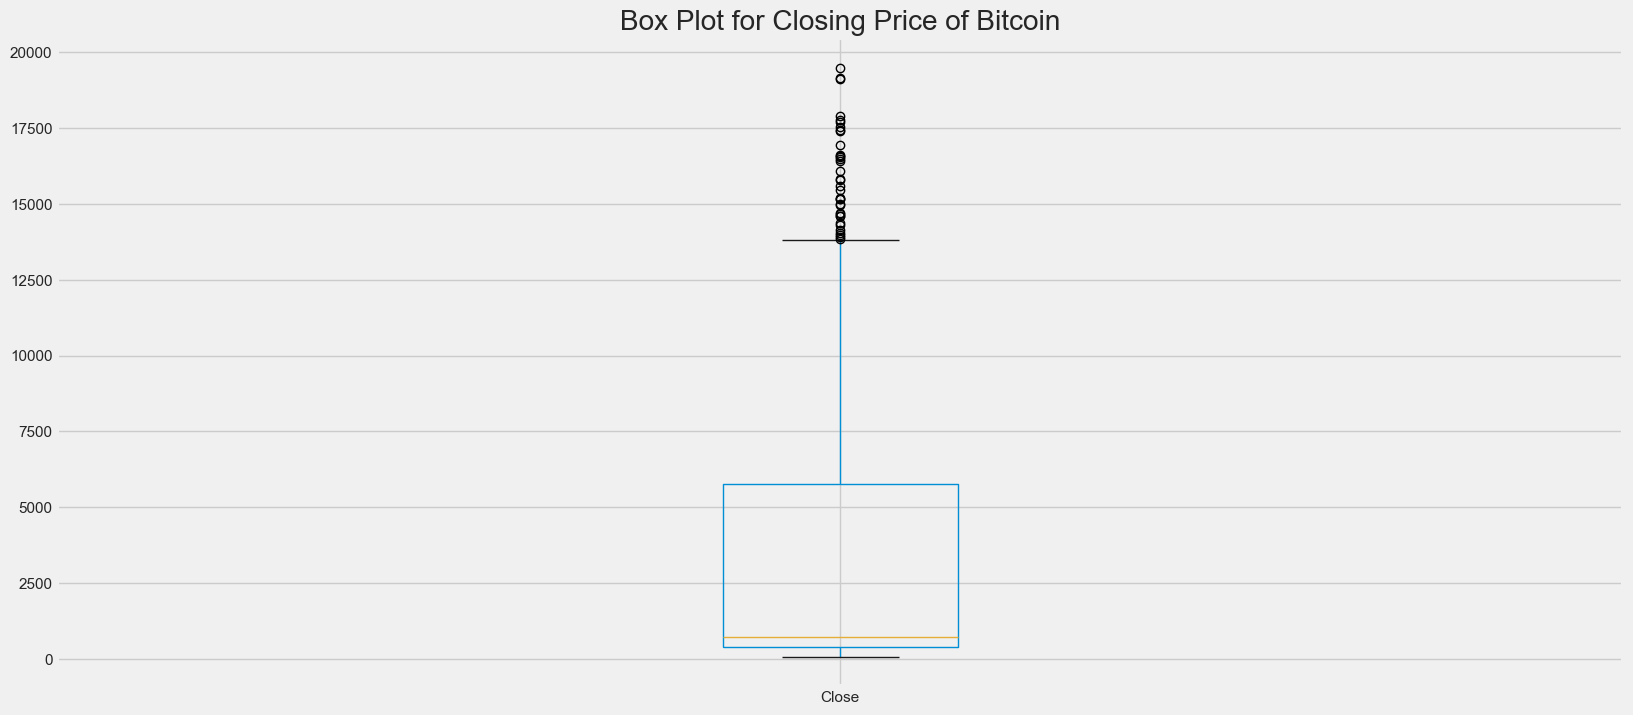

In [132]:
ax=df_bt.boxplot()
ax.set_title("Box Plot for Closing Price of Bitcoin")
plt.show()


(array([15340., 15706., 16071., 16436., 16801., 17167., 17532., 17897.,
        18262.]),
 [Text(15340.0, 0, '2012'),
  Text(15706.0, 0, '2013'),
  Text(16071.0, 0, '2014'),
  Text(16436.0, 0, '2015'),
  Text(16801.0, 0, '2016'),
  Text(17167.0, 0, '2017'),
  Text(17532.0, 0, '2018'),
  Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020')])

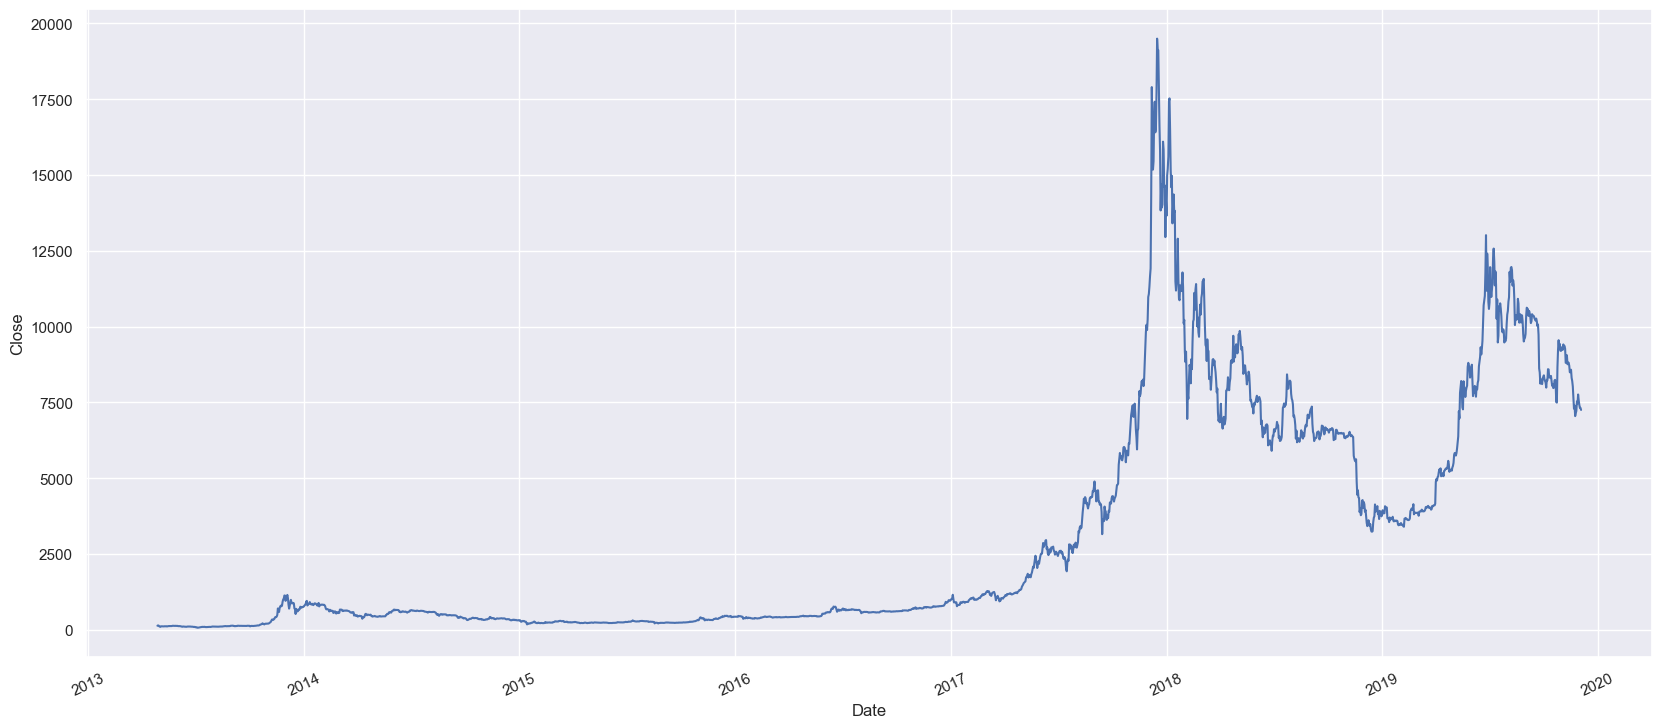

In [133]:
sns.set()
plt.ylabel('Close')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(df_bt.index, df_bt['Close'])
plt.xticks(rotation = 25)

In [134]:
result = adfuller(df_bt["Close"])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
  print("Reject Ho — Time Series is Stationary!")
  
else:
  print("Failed to reject Ho — Time Series is not Stationary!")

ADF Statistic: -2.034025
p-value: 0.271856
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Failed to reject Ho — Time Series is not Stationary!


The ADF test fails to reject the hypothesis that the data is non-stationary, implying that the data does not have constant variance over time. It is stochastic in nature and needs to deal with a method that fully addresses the issue. 

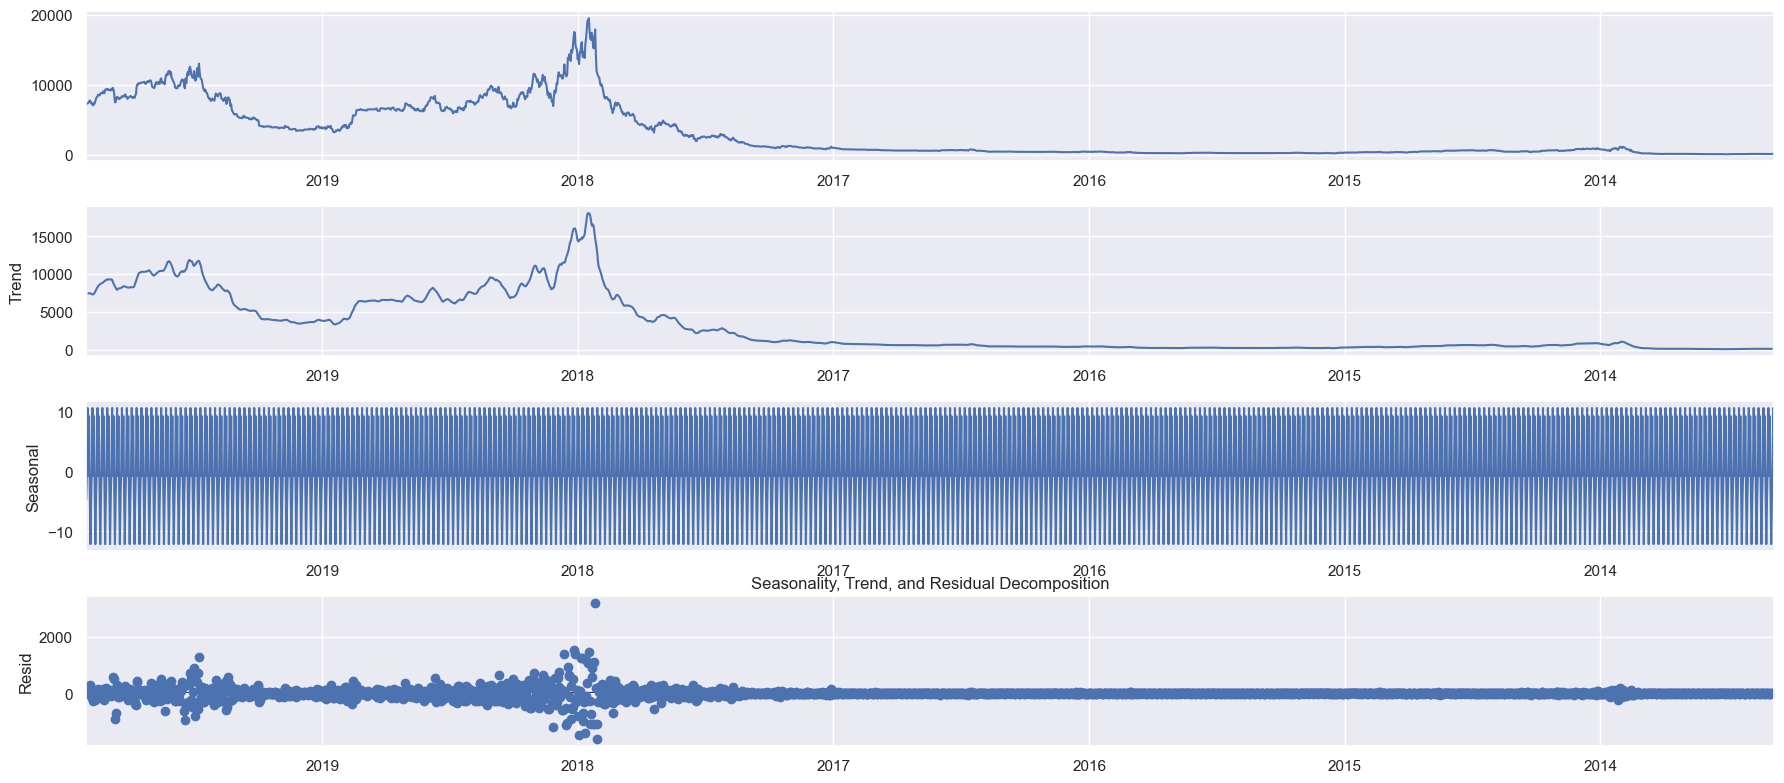

<Figure size 1800x800 with 0 Axes>

In [135]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
result= df_bt.loc[:,['Close']]
decomposition = sm.tsa.seasonal_decompose(result, model='additive')
decomposition.plot()
plt.title('Seasonality, Trend, and Residual Decomposition')
plt.show()
plt.savefig('Seasonal_decompose.png')

In [136]:
df_redecomp = pd.concat([decomposition.seasonal, decomposition.trend, decomposition.resid, decomposition.observed], axis = 1)
df_redecomp.columns = ['Actual', 'Seasonal', 'trend', 'residual']
df_redecomp

,Actual,Seasonal,trend,residual
Date,,,,
2019-12-04,-4.66,NaN,NaN,"7,252.03"
2019-12-03,0.57,NaN,NaN,"7,320.15"
2019-12-02,10.63,NaN,NaN,"7,321.99"
2019-12-01,-0.75,"7,444.63",-19.60,"7,424.29"
2019-11-30,9.25,"7,484.58",75.80,"7,569.63"
...,...,...,...,...
2013-05-02,-12.16,118.84,-1.47,105.21
2013-05-01,-4.66,121.46,0.19,116.99
2013-04-30,0.57,NaN,NaN,139.00


The decomposition shows the data has both seasonality and trend component. However, we are unable to separate the noise from the linear trend. That is the data exhibits some kind of unstability mainly for the period of 2017 to 2019 along with seasonality feature. Perhaps, we can get almost similar result if we twist our model to the method of Multiplicative decomposition. 

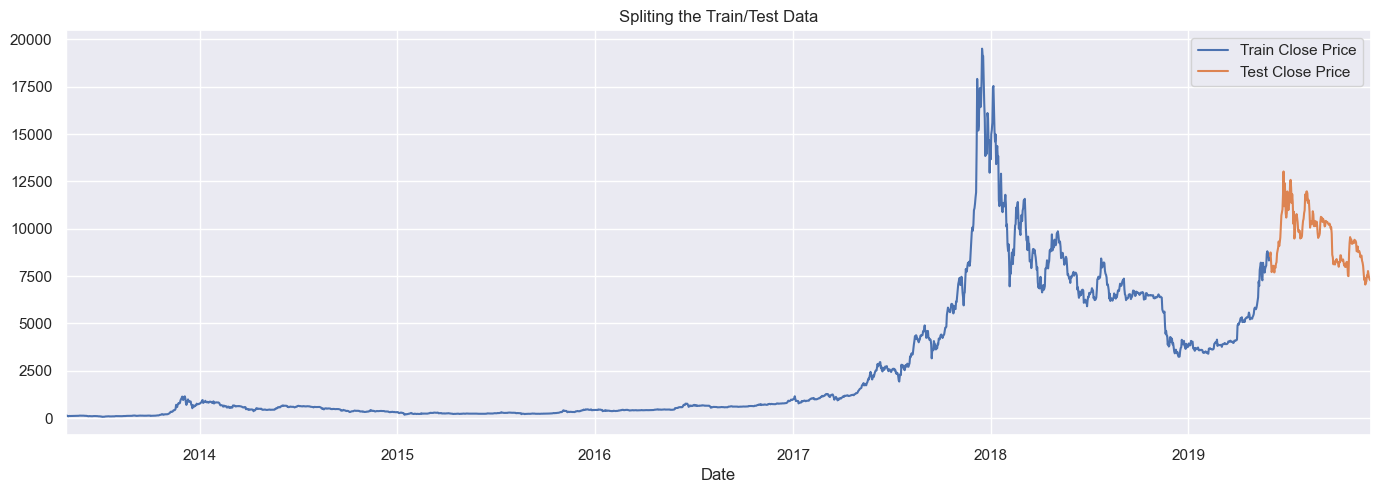

<Figure size 1800x800 with 0 Axes>

In [137]:
train= df_bt[df_bt.index < pd.to_datetime("2019-06-01", format='%Y-%m-%d')]
test=df_bt[df_bt.index >= pd.to_datetime("2019-06-01", format='%Y-%m-%d')]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Train Close Price', title='Spliting the Train/Test Data')
test.plot(ax=ax, label='Test Close Price')
ax.legend(['Train Close Price', 'Test Close Price'])
plt.show()

plt.savefig('Train-split.png')

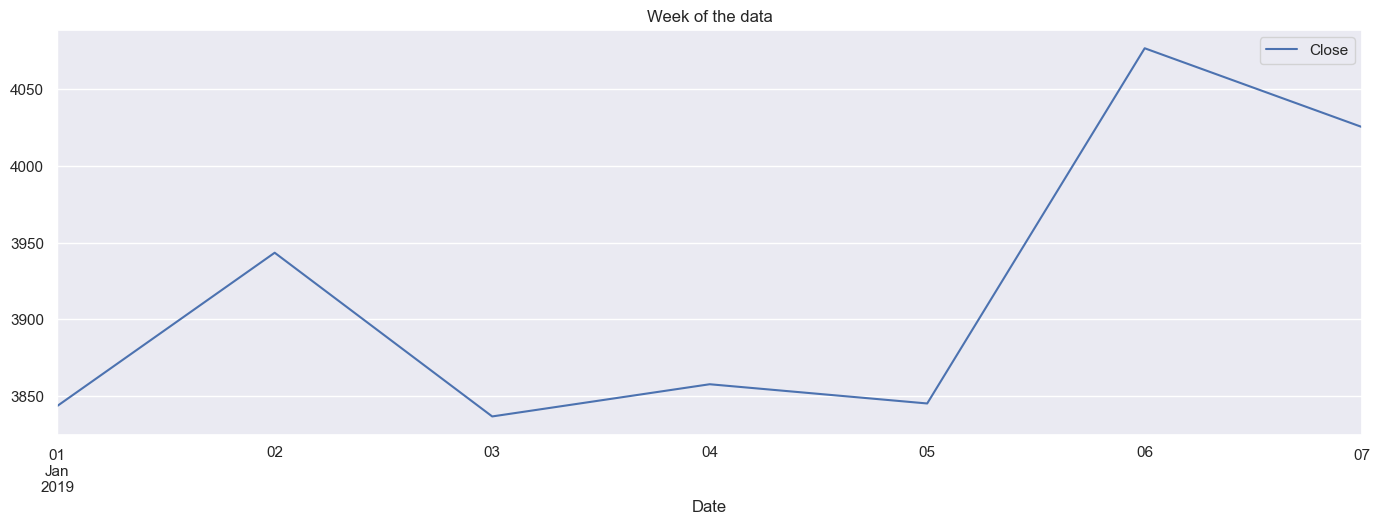

In [138]:
#The Closing Price for the first week of January 2019
df_bt.loc[(df_bt.index >= '2019-01-01') & (df_bt.index < '2019-01-08')] \
    .plot(figsize=(15,5), title= 'Week of the data')
plt.show()

In [139]:
def create_features(df_bt):
    """
    Time series features
    """
    df_bt=df_bt.copy()
    df_bt['hour'] = df_bt.index.hour
    df_bt['dayofweek'] = df_bt.index.dayofweek
    df_bt['quarter'] = df_bt.index.quarter
    df_bt['month'] = df_bt.index.month
    df_bt['year'] = df_bt.index.year
    df_bt['dayofyear'] = df_bt.index.dayofyear
    df_bt['dayofmonth'] = df_bt.index.day
    df_bt['weekofyear'] = df_bt.index.isocalendar().week
    return df_bt

df_bt = create_features(df_bt)

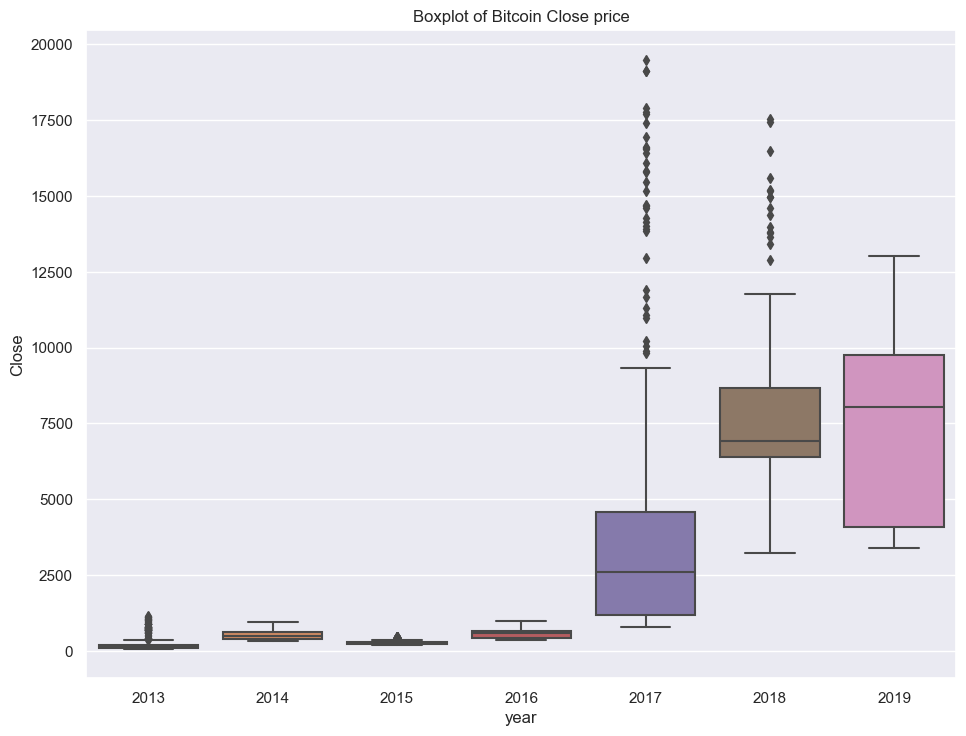

<Figure size 1800x800 with 0 Axes>

In [140]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_bt, x='year', y='Close')
ax.set_title('Boxplot of Bitcoin Close price')
plt.show()
plt.savefig('boxplot_close.png', dpi=600)

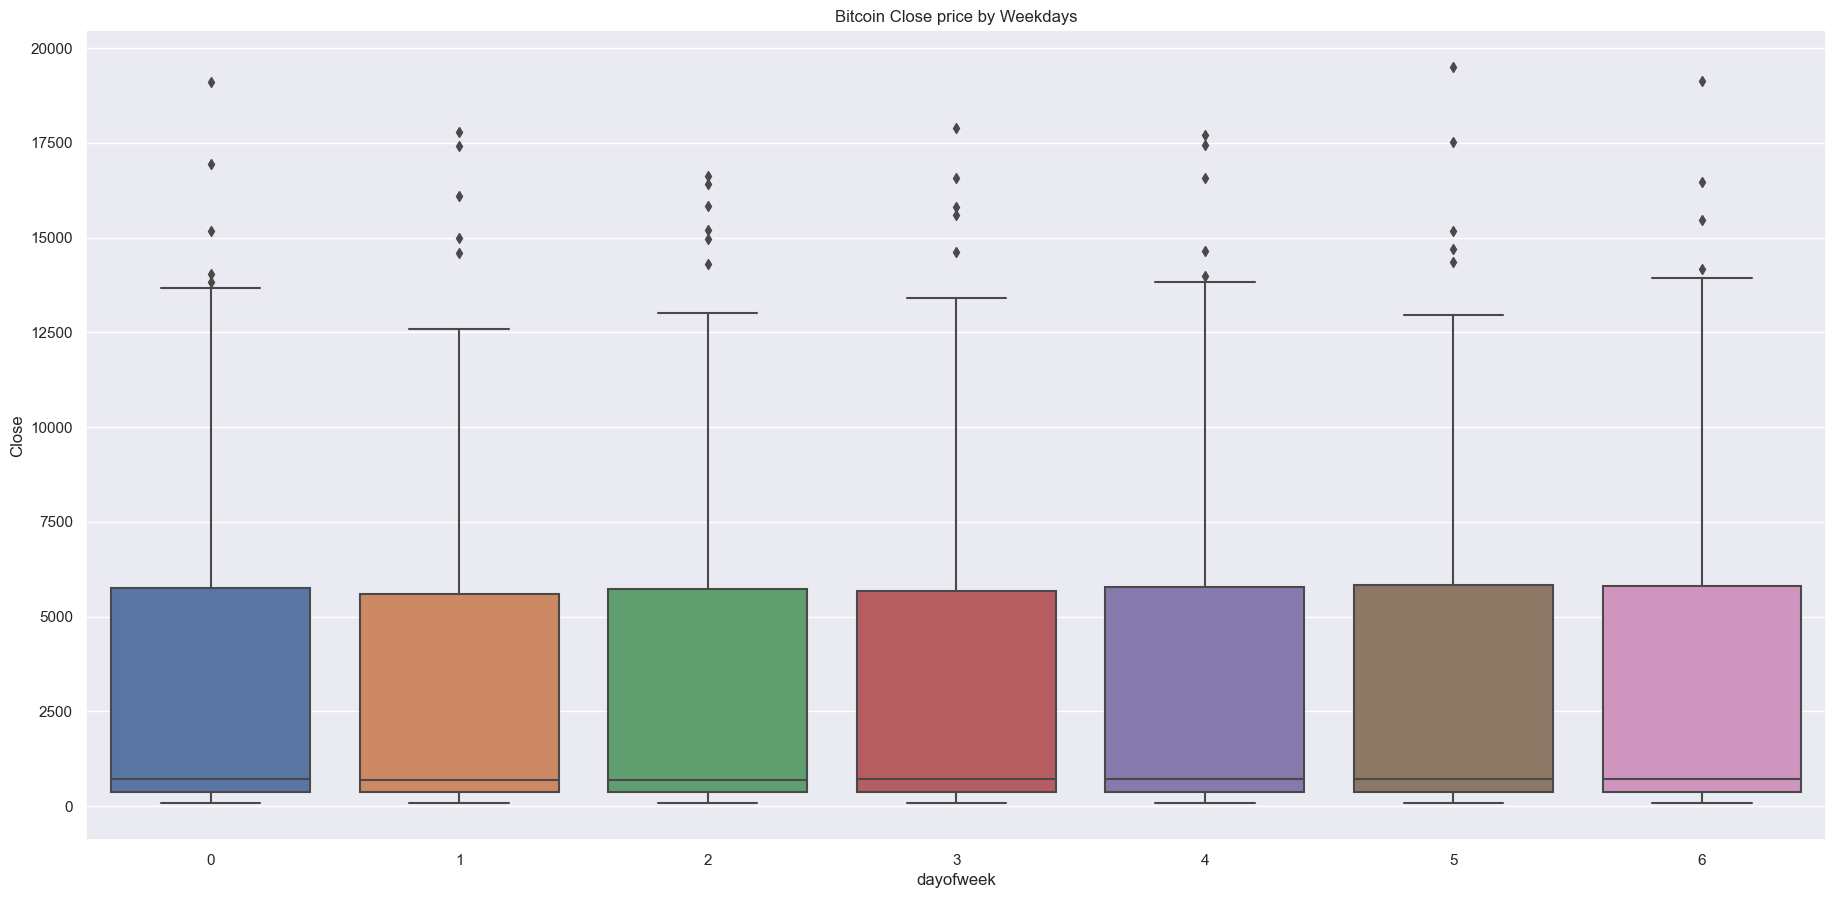

<Figure size 1800x800 with 0 Axes>

In [141]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(data=df_bt, x='dayofweek', y='Close')
ax.set_title('Bitcoin Close price by Weekdays')
plt.show()
plt.savefig('boxplot_wkdays.png', dpi=300)

In [142]:
train = create_features(train)
test = create_features(test)
testing_data = df_bt.loc[df_bt['Date']>="2019-06-01"]
testing_dates=testing_data["Date"]

FEATURES = ['dayofyear','dayofweek', 'quarter', 'month', 'year']
TARGET = 'Close'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [143]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[14:11:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4152.58664	validation_1-rmse:9560.08347
[100]	validation_0-rmse:1913.40234	validation_1-rmse:6361.55526
[200]	validation_0-rmse:1200.48263	validation_1-rmse:4738.54126
[300]	validation_0-rmse:760.68030	validation_1-rmse:4224.83060
[400]	validation_0-rmse:593.84528	validation_1-rmse:4030.03656
[500]	validation_0-rmse:509.51625	validation_1-rmse:3246.70757
[600]	validation_0-rmse:462.07399	validation_1-rmse:2966.35995
[700]	validation_0-rmse:420.68627	validation_1-rmse:2780.44580
[800]	validation_0-rmse:392.09310	validation_1-rmse:2761.98059
[900]	validation_0-rmse:375.77254	validation_1-rmse:2742.55477
[982]	validation_0-rmse:362.69458	validation_1-rmse:2750.00255


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

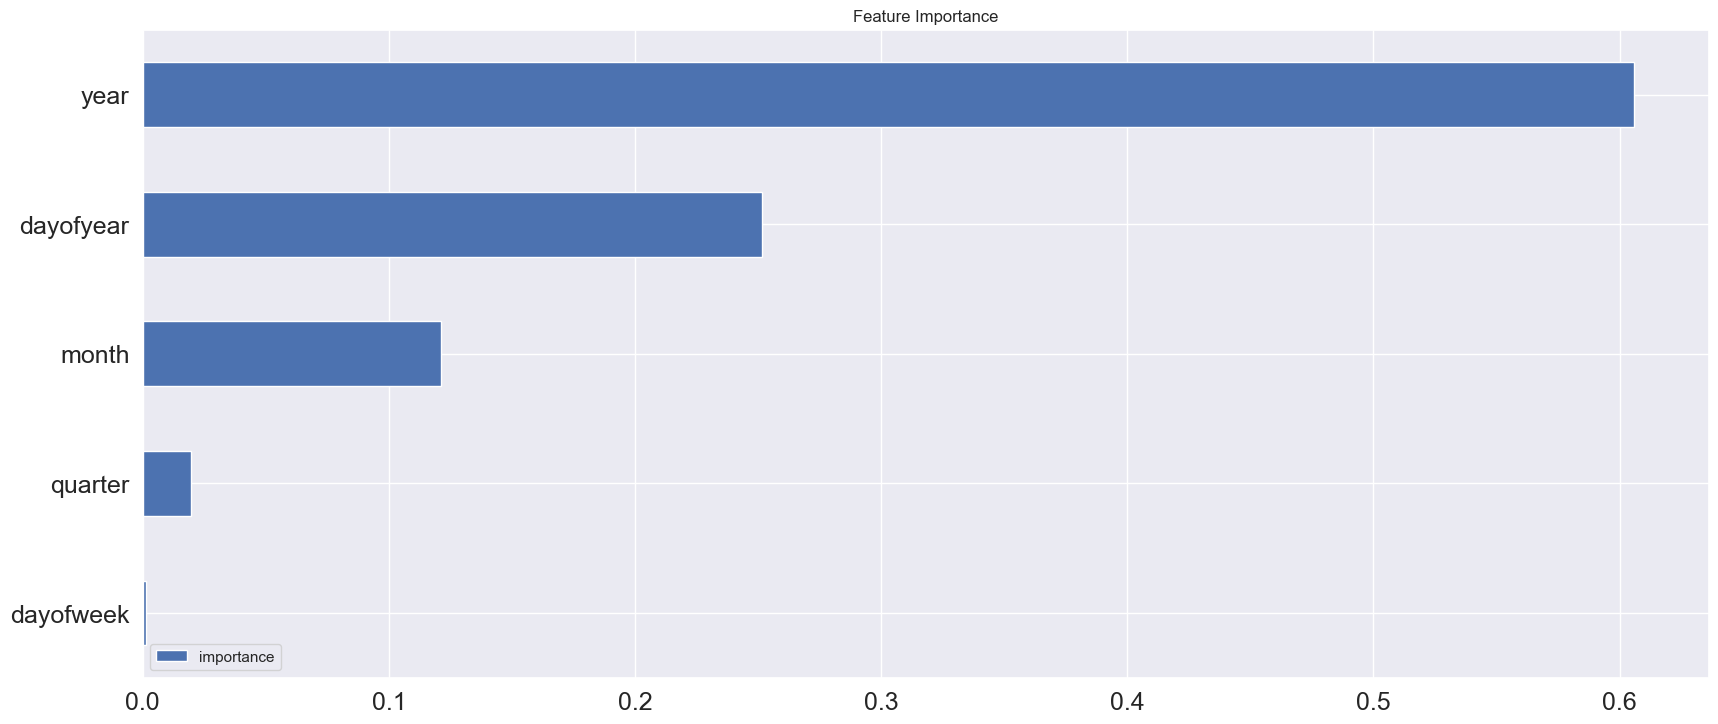

<Figure size 1800x800 with 0 Axes>

In [144]:
feat_imp = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
feat_imp.sort_values('importance').plot(kind='barh', title='Feature Importance', fontsize= 18)
plt.show()
plt.savefig('importance.png', dpi=300)

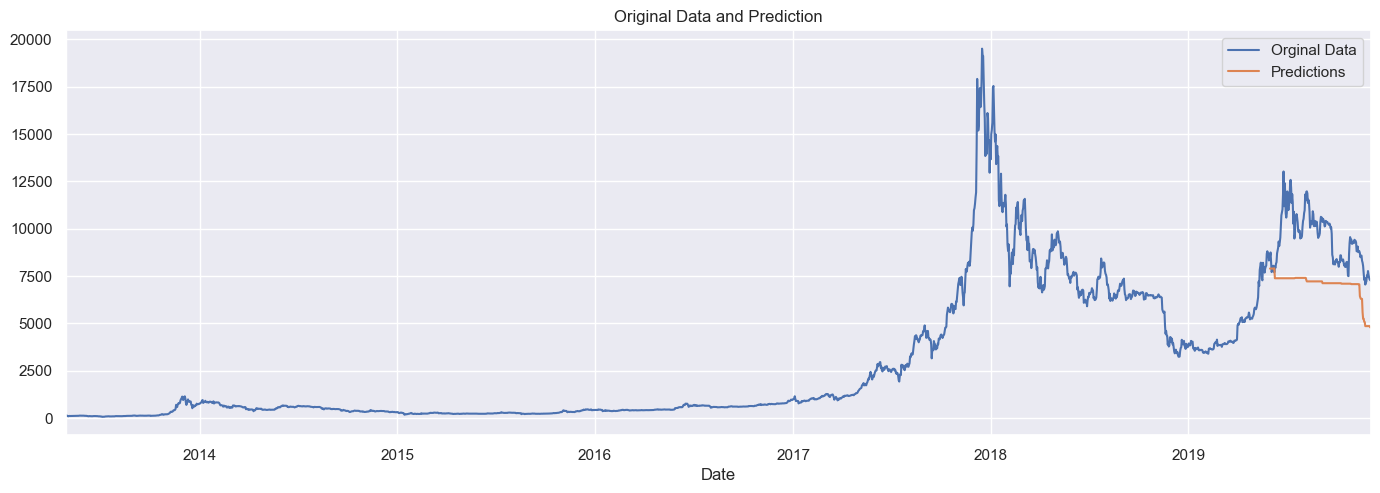

<Figure size 1800x800 with 0 Axes>

In [145]:
test['Predictions'] = reg.predict(X_test)
df_bt = df_bt.merge(test[['Predictions']], how='left', left_index=True, right_index=True)
ax = df_bt[['Close']].plot(figsize=(15, 5))
df_bt['Predictions'].plot(ax=ax, style='-')
plt.legend(['Orginal Data', 'Predictions'])
ax.set_title('Original Data and Prediction')
plt.show()
plt.savefig('predictXGBoost.png', dpi=300)


In [146]:

rmse = np.sqrt(mean_squared_error(test['Close'], test['Predictions']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3268.45


In [147]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=1)
df_bt = df_bt.sort_index()


In [148]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    fold += 1


In [149]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_bt):
    train = df_bt.iloc[train_idx]
    test = df_bt.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear','dayofweek', 'quarter', 'month', 'year']
    TARGET = 'Close'

    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[14:11:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:486.16372	validation_1-rmse:263.14041
[100]	validation_0-rmse:189.10624	validation_1-rmse:129.85512
[111]	validation_0-rmse:171.34254	validation_1-rmse:145.32914
[14:11:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:415.63118	validation_1-rmse:549.00067
[100]	validation_0-rmse:172.98846	validation_1-rmse:387.47917
[200]	validation_0-rmse:85.34358	validation_1-rmse:325.96767
[300]	validation_0-rmse:56.82803	validation_1-rmse:304.42093
[400]	validation_0-rmse:44.71429	validation_1-rmse:296.57099
[500]	validation_0-rmse:38.32624	validation_1-rms

In [150]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2630.0920
Fold scores:[90.96670970231521, 293.480176075773, 3208.016037986909, 6289.546743542862, 3268.4503019292692]


In [151]:
test['error'] = np.abs(test[TARGET] - test['Predictions'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10) # the worst predicted value (for the best prediction change ascending=True)

date
2019-06-26   5,634.94
2019-07-09   5,192.52
2019-06-28   5,026.04
2019-07-08   4,904.67
2019-07-10   4,775.22
2019-08-08   4,750.26
2019-08-09   4,646.79
2019-08-07   4,646.47
2019-07-03   4,579.98
2019-06-29   4,578.08
Name: error, dtype: float64

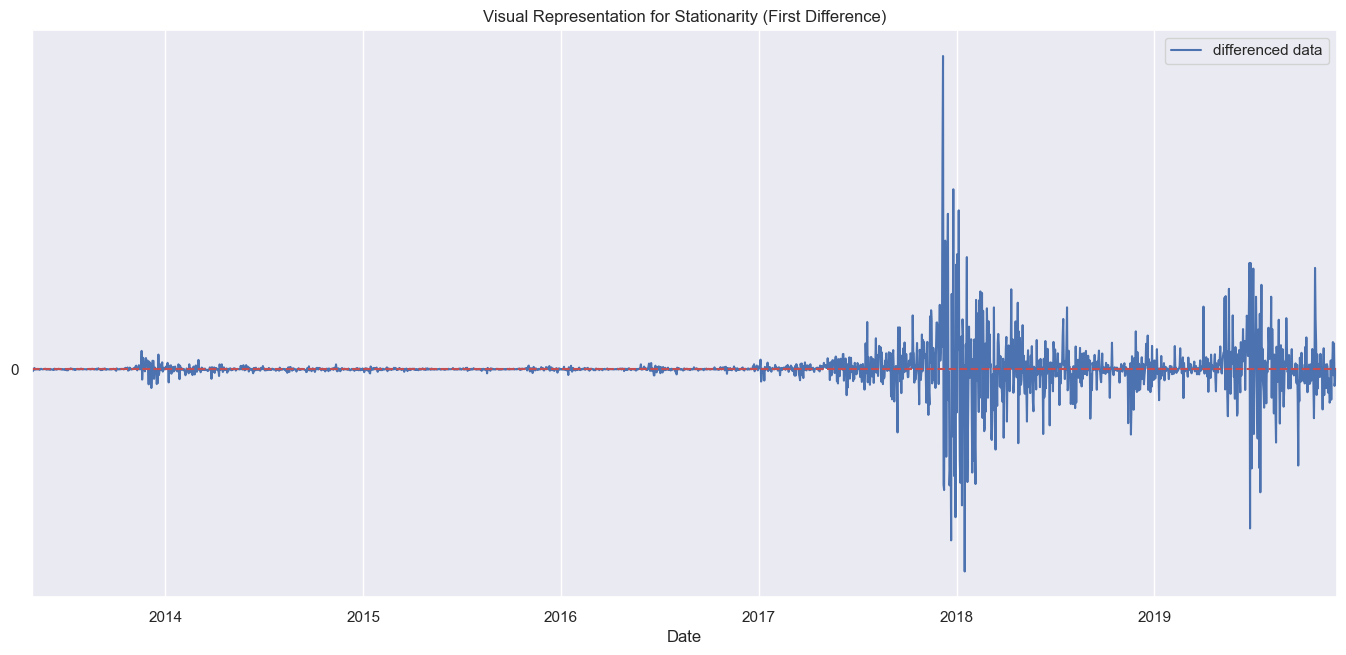

<Figure size 1800x800 with 0 Axes>

In [152]:
#First differencing to remove the non-stationarity behavior of the data
df_diff = df_bt["Close"].diff().dropna()
fig, ax=plt.subplots(figsize=(15,7))
df_diff.plot.line(ax=ax, label='differenced data')
ax.axhline('0', color='r', linestyle='--')
plt.title('Visual Representation for Stationarity (First Difference)')
plt.legend()
plt.show()
plt.savefig('stationarity.png')

In [153]:
#Checking the stationarity of the data after first differencing
stat = adfuller(df_diff)

print('ADF Statistic: %f' % stat[0])
print('p-value: %f' % stat[1])
print('Critical Values:')

for key, value in stat[4].items():
  print('\t%s: %.3f' % (key, value))

if stat[0] < stat[4]["5%"]:
  print("Reject Ho — Time Series is Stationary!")
  
else:
  print("Failed to reject Ho — Time Series is not Stationary!")

ADF Statistic: -9.416742
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Reject Ho — Time Series is Stationary!


In [154]:
p_values= [0, 1, 2]
d_values= [0, 1]
q_values= [0, 1, 2]
P_values= [0, 1, 2]
D_values= [0, 1]
Q_values= [0, 1, 2]
s_values= [12]

In [155]:
#Grid Search
best_rmse =float('inf')
best_params =None

for p, d, q, P, D, Q, s in product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    try:
        model=SARIMAX(train, order= (p, d, q), seasonal_order=(P, D, Q, s))
        result =model.fit(disp=False)
        forecast_steps=len(test)
        forecast= result.get_forecast(steps=forecast_steps)
        predicted_values=forecast.predicted.mean
        rmse=np.sqrt(mean_squared_error(test['Close'], predicted_values))
        
        if rmse < best_rmse:
            best_rmse=rmse
            best_params= (p, d, q, P, D, Q, s)
    except:
        continue
    print(f"Best RMSE: {best_rmse: .2f} with parameters {best_params}")
        

In [156]:
# Define the p, d and q  
p = d = q = range(0, 2)

# Generating different combinations of p, q and q 
pdq = list(itertools.product(p, d, q))

# Generating combinations of seasonal p, q and q 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [157]:
import warnings
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_bt['Close'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:47750.597727881686
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:45906.47598587258
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:39454.91327641382
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:39268.291002774284
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:39463.00950416366
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:39444.717080726
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:39283.83903455911
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:39269.81489662563
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:45961.76826402847
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:45321.248704532045
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:37117.602110893116
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:36935.60328726942
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:37134.160414633494
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:37100.573132628895
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:36965.24859059899
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:36932.57701423826
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:33441.68952586276
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:33287.

In [158]:
mod = sm.tsa.statespace.SARIMAX(train['Close'],
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7148      0.040    -17.727      0.000      -0.794      -0.636
ma.L1          0.7720      0.038     20.408      0.000       0.698       0.846
ar.S.L12      -0.0189      0.007     -2.639      0.008      -0.033      -0.005
ma.S.L12      -1.0000      0.007   -139.028      0.000      -1.014      -0.986
sigma2      6.211e+04   1.16e-07   5.36e+11      0.000    6.21e+04    6.21e+04


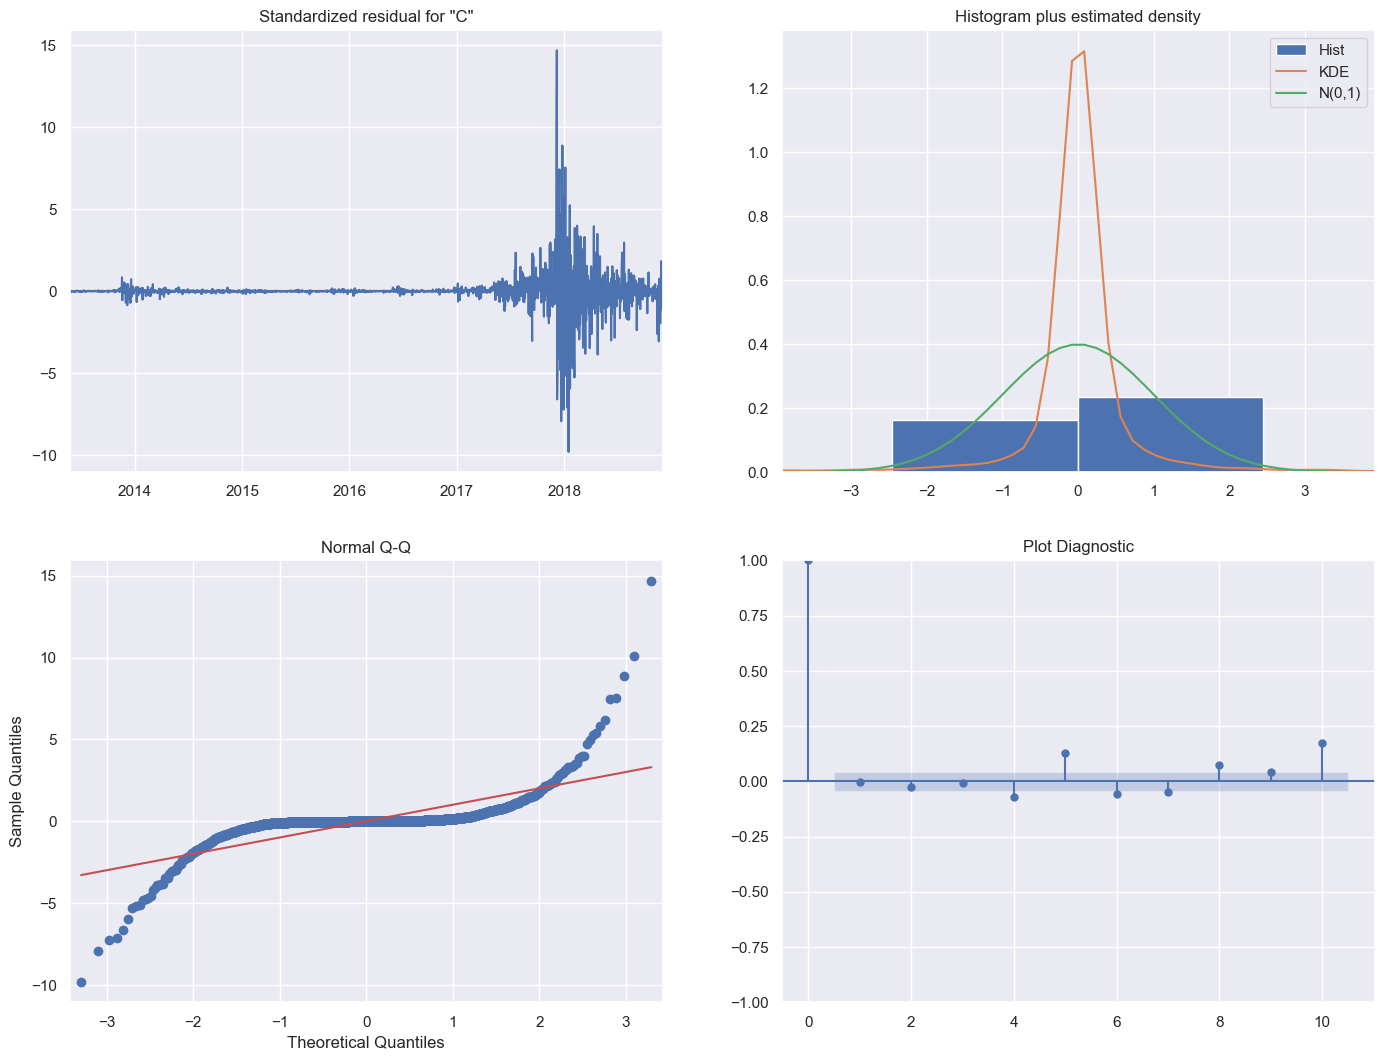

<Figure size 1800x800 with 0 Axes>

In [159]:
output.plot_diagnostics(figsize=(15, 12))
plt.title('Plot Diagnostic')
plt.show()
plt.savefig('diagnostic.png')

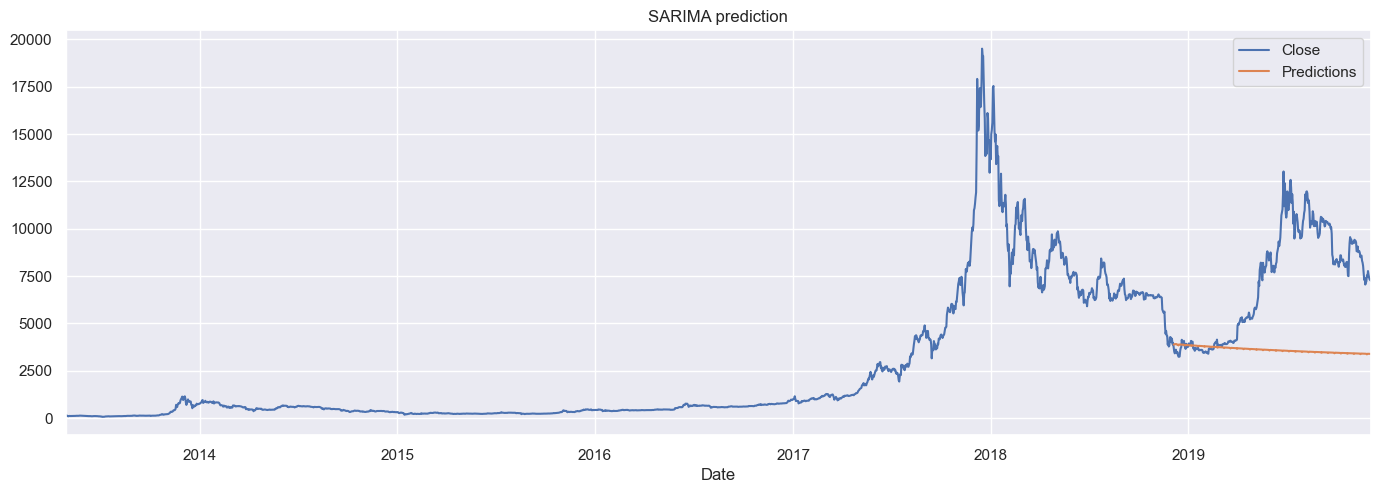

In [160]:
yhat = output.get_forecast(len(test.index))
yhat_df = yhat.conf_int(alpha = 0.05) 
yhat_df["Predictions"] = output.predict(start = yhat_df.index[0], end = yhat_df.index[-1])
yhat_df.index = test.index
yhat_out = yhat_df["Predictions"] 

ax = df_bt[['Close']].plot.line(figsize=(15, 5))
yhat_df['Predictions'].plot.line(ax=ax, style='-')
plt.legend(['Observed', 'SARIMA Predictions'])
plt.title('SARIMA prediction')
plt.legend()
plt.savefig('sarima.png', dpi=300)

In [161]:
mse = np.sqrt(mean_squared_error(test['Close'], yhat_df['Predictions']))
print('MSE: '+str(mse))
#mae = mean_absolute_error(test['Close'], yhat_df['Predictions'])
#print('MAE: '+str(mae))

MSE: 4581.673714636281


In [162]:
fore = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True)
fore_ci = fore.conf_int()

In [163]:
# Get forecast 500 steps ahead in future
#pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
#pred_ci = pred_uc.conf_int()

In [164]:
#ax = df_bt['2018-01-01':].plot(label='observed', figsize=(20, 15))
#fore.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

#ax.fill_between(fore_ci.index,
                #fore_ci.iloc[:, 0],
                #fore_ci.iloc[:, 1], color='k', alpha=.2)

#ax.set_xlabel('Date')
#ax.set_ylabel('Bitcoin Closing Price')
#plt.legend()

#plt.show()
#plt.savefig('forecast.png')